In [4]:
# Importing required modules/libraries
import re
import time
import warnings
import pandas as pd
import regex as re
import requests
import seaborn as sns
from bs4 import BeautifulSoup
import concurrent.futures
warnings.filterwarnings("ignore")

# Finding user agent at: https://httpbin.org/get

"""
Comments Scraping (Extraction) (Currently Amazon Specific)
"""


class ScrapeComments:

    def __init__(self, cmts_url, max_reviews, headers):

        # Device Specific Headers
        self.head = headers

        self.df_comments = self.getAmazonComments(cmts_url, max_reviews)

    # Function that returns the Data Frame created (extracted comments)
    def getDf(self):
        return self.df_comments

    # Main Function that extracts and converts the comments into a structured dataframe
    def getAmazonComments(self, cmts_url, max_reviews):

        # Counters
        page_no = 0  # All reviews --> current page number counter
        reviews = 0  # Total reviews extracted counter
        reviews_count = 0  # Counter initialised to prevent item called before assignment error

        # Empty lists that will hold all reviewee data like name, date of review, ratings gien, review title, content
        customer_name = []
        review_date = []
        ratings = []
        review_title = []
        review_content = []
        # global reviews_soup

        # Finding the url to the queried product name using indexing
        #item_url = list(df['product_url'][df['product_name'] == onclick_name])[0]

        item_url = cmts_url

        # Connecting (sending a request) to the product's page
        item_page = requests.get(item_url, headers=self.head)
        item_soup = BeautifulSoup(item_page.content, "html.parser")

        try:

            # Till the reviews counter is less than the reviews_count mentioned on the 'all reviews' page
            while reviews <= reviews_count:

                # Finding the link to "all reviews on the product's page", and adding iterating page_no variable
                reviews_url = item_soup.find('a', {'class': 'a-link-emphasis a-text-bold'})['href']
                reviews_url = "https://www.amazon.in" + reviews_url + "&pageNumber=" + str(page_no)

                # Sending request for the Reviews Url page
                reviews_page = requests.get(reviews_url, headers=self.head)
                reviews_soup = BeautifulSoup(reviews_page.content, "html.parser")


                # Number of reviews for the particular page, same throughout all comment (all reviews) pages
                reviews_count = reviews_soup.find('div', {'class': "a-row a-spacing-base a-size-base"}).text
                reviews_count = int(
                    (reviews_count.strip().split('ratings,'))[1].split('with')[0].strip().replace(",", ""))
                print(reviews_count)
                # Extracting the required comments in a page
                # These are generally lists containing 10 review related data each.
                names = reviews_soup.select('span.a-profile-name')[2:]
                titles = reviews_soup.select('a.review-title span')
                dates = reviews_soup.select('span.review-date')[2:]
                stars = reviews_soup.select('i.review-rating span.a-icon-alt')[2:]
                content = reviews_soup.select('span.review-text-content span')

                # IndexError Handling : If the sections are left empty by the customers, the index is out of range
                for count in range(len(dates)):

                    try:
                        customer_name.append(names[count].get_text())
                    except IndexError:
                        customer_name.append(0)

                    try:
                        review_date.append(dates[count].get_text().replace("Reviewed in India on ", ""))
                    except IndexError:
                        review_date.append(0)

                    try:
                        review_title.append(titles[count].get_text())
                    except IndexError:
                        review_title.append(None)

                    try:
                        ratings.append(float(stars[count].get_text()[:2]))
                    except IndexError:
                        ratings.append(None)

                    try:
                        review_content.append(content[count].get_text())
                    except IndexError:
                        review_content.append(None)

                    reviews = reviews + 1

                # Incase the number of reviews counter has reached the maximum reviews to be extracted
                if reviews == max_reviews:
                    break

                page_no = page_no + 1
                # print(page_no)


        except:
            pass

        """
        Debugging Section
        print(len(customer_name))
        print(len(review_date))
        print(len(review_title))
        print(len(ratings))
        print(len(review_content))
        """

        # Recalling required functions from the module.
        df = self.commentsToDf(customer_name, review_date, review_title, ratings, review_content)
        df = self.cleanReviewDates(df)

        return df

    # Function that assigns the lists extracted to a dataframe and returns it.
    def commentsToDf(self, names, dates, titles, ratings, content):

        reviews_df = pd.DataFrame({"customer_name": names,
                                   "review_date": dates,
                                   "review_title": titles,
                                   "review_ratings": ratings,
                                   "review_content": content})

        return reviews_df

    # Function to convert dates which have indian flag and incorrect redundant formats in it, st object in dd/mm/yy
    def cleanReviewDates(self, df):

        cleaned_dates = []
        for comment in list(df['review_date']):
            for string in range(len(comment)):
                if comment[string].isnumeric():
                    cleaned_dates.append(comment[string:])
                    break

        df['review_date'] = cleaned_dates
        df['review_date'] = pd.to_datetime(df['review_date']).dt.strftime('%d/%m/%Y')

        return df
product_url = "https://www.amazon.in/American-Tourister-27O-70-003/dp/B073XL19QZ/ref=rtpb_sccl_2/261-9191745-8965641?pd_rd_w=p9BkD&content-id=amzn1.sym.27e14dfa-fd84-42ef-ba2a-ff2c76de3f35&pf_rd_p=27e14dfa-fd84-42ef-ba2a-ff2c76de3f35&pf_rd_r=ZHB3SFAV8MKCY98FCAA5&pd_rd_wg=ymbDM&pd_rd_r=e112ff65-fc9a-4ab8-8525-f55c8148956d&pd_rd_i=B073XL19QZ&psc=1"

# Define the maximum number of reviews to be extracted
max_reviews = 50

# Define the headers for the request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept-Language': 'en-US, en;q=0.5'
}

# Create an instance of ScrapeComments
sc = ScrapeComments(cmts_url=product_url, max_reviews=max_reviews, headers=headers)

# Get the DataFrame with extracted reviews
reviews_df = sc.getDf()

# Display the DataFrame
print(reviews_df)

Empty DataFrame
Columns: [customer_name, review_date, review_title, review_ratings, review_content]
Index: []


In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

# Function to extract Product Title
def get_title(soup):
    try:
        # Outer Tag Object
        title = soup.find("span", attrs={"id": 'productTitle'})

        # Inner NavigatableString Object
        title_value = title.text

        # Title as a string value
        title_string = title_value.strip()

    except AttributeError:
        title_string = ""
    return title_string

# Function to extract Product Price
def get_price(soup):
    try:
        price = soup.find("span", attrs={'class': 'a-price a-text-price'}).string.strip()

    except AttributeError:
        try:
            # If there is some deal price
            price = soup.find("span", attrs={'id': 'priceblock_dealprice'}).string.strip()

        except:
            price = ""

    return price

# Function to extract Product Rating
def get_rating(soup):
    try:
        rating = soup.find("i", attrs={'class': 'a-icon a-icon-star a-star-4-5'}).string.strip()

    except AttributeError:
        try:
            rating = soup.find("span", attrs={'class': 'a-icon-alt'}).string.strip()
        except:
            rating = ""

    return rating

# Function to extract Number of User Reviews
def get_review_count(soup):
    try:
        review_count = soup.find("span", attrs={'id': 'acrCustomerReviewText'}).string.strip()

    except AttributeError:
        review_count = ""

    return review_count

# Function to extract Availability Status
def get_availability(soup):
    try:
        available = soup.find("div", attrs={'id': 'availability'})
        available = available.find("span").string.strip()

    except AttributeError:
        available = "Not Available"

    return available

# Function to extract Product Reviews
def get_reviews(soup):
    reviews = []
    review_items = soup.find_all("div", attrs={"data-hook": "review"})

    for review in review_items:
        review_text = review.find("span", attrs={"data-hook": "review-body"}).text.strip()
        reviews.append(review_text)

    return reviews

def scrape_amazon_data(keyword):
    HEADERS = {'User-Agent': '', 'Accept-Language': 'en-US, en;q=0.5'}

    # Build the URL dynamically
    URL = f"https://www.amazon.com/s?k={keyword}"

    # HTTP Request
    webpage = requests.get(URL, headers=HEADERS)

    # Soup Object containing all data
    soup = BeautifulSoup(webpage.content, "html.parser")

    # Fetch links as List of Tag Objects
    links = soup.find_all("a", attrs={'class': 'a-link-normal s-no-outline'})

    # Store the links
    links_list = []

    # Loop for extracting links from Tag Objects
    for link in links:
        links_list.append(link.get('href'))

    d = {"title": [], "price": [], "rating": [], "reviews": [], "availability": []}

    # Loop for extracting product details from each link
    for link in links_list:
        new_webpage = requests.get("https://www.amazon.com" + link, headers=HEADERS)

        new_soup = BeautifulSoup(new_webpage.content, "html.parser")

        # Function calls to display all necessary product information
        d['title'].append(get_title(new_soup))
        d['price'].append(get_price(new_soup))
        d['rating'].append(get_rating(new_soup))
        d['availability'].append(get_availability(new_soup))
        d['reviews'].append(get_review_count(new_soup))

    amazon_df = pd.DataFrame.from_dict(d)

    # Remove rows with missing titles
    amazon_df['title'].replace('', np.nan, inplace=True)
    amazon_df = amazon_df.dropna(subset=['title'])

    # Scrape product reviews for each link
    reviews_list = []
    for link in links_list:
        review_webpage = requests.get("https://www.amazon.com" + link, headers=HEADERS)
        review_soup = BeautifulSoup(review_webpage.content, "html.parser")
        reviews = get_reviews(review_soup)
        reviews_list.append(reviews)

    # Add reviews column to the DataFrame
    amazon_df['reviews'] = reviews_list

    amazon_df.to_csv("amazon_data.csv", header=True, index=False)

    return amazon_df

# Example usage:
keyword_to_search = "laptop"
scraped_data = scrape_amazon_data(keyword_to_search)
print(scraped_data.head())


Empty DataFrame
Columns: [title, price, rating, reviews, availability]
Index: []


In [ ]:
text_total = " ".join(df["Reviews"])

In [ ]:
text_total[:2000]

"Nice product\nRead more Very sturdy and works fine. Very fast in opening any app compared to windows laptop. Very light weight, long lasting battery\nRead more Overall, it has been a good experience. Transaction was smooth and swift. Accessories came in as promised. Mouse was faulty and had to be replaced, which was easy and swift (that's Amazon). M2 is quite easy to use and equipped with innovative features for the inquisitive user. Yes, it may take a while to learn and get used to the new commands...but it's worth it...anyway, learning never stops. Can recommend buying through Amazon without hesitation.\nRead more The media could not be loaded.\n                \n\n\nRead more The media could not be loaded.\n                \n\n\n\n\xa0One of the most premium & lightest laptop , works fast and seemless with my iPhone. Display is beautiful and looks very modern and fancy. Build quality is great! Speakers are stereo and have high volume capacity without any distortion. Everything is b

In [ ]:
chars = sorted(list(set(text_total)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !&'(),.289ABCDEILMNOPRSTVYabcdefghiklmnopqrstuvwxyz 
54


In [ ]:
df_new = df.copy()


In [ ]:
import re
import string

In [ ]:
def cleaning_text(text):
 text = text.lower()
 text = re.sub('😤', "", text)
 text = re.sub('\[.*?\]', '', text)
 text = re.sub('https?://\S+|www\.\S+', '', text)
 text = re.sub('<.*?>+', '', text)
 text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
 text = re.sub('[‘’“”…]', '', text)
 return text
cleaning = lambda x: cleaning_text(x)

In [ ]:
df_new['Cleaned_Reviews'] = df_new.Reviews.apply(cleaning)
df_new


,Reviews,Cleaned_Reviews
0,Nice product\nRead more,nice product\nread more
1,Very sturdy and works fine. Very fast in openi...,very sturdy and works fine very fast in openin...
2,"Overall, it has been a good experience. Transa...",overall it has been a good experience transact...
3,The media could not be loaded.\n ...,the media could not be loaded\n ...
4,The media could not be loaded.\n ...,the media could not be loaded\n ...
5,The media could not be loaded.\n ...,the media could not be loaded\n ...
6,Product is ok but the internal storage is too ...,product is ok but the internal storage is too ...
7,Amazing Laptop\nRead more,amazing laptop\nread more
8,Nice product\nRead more,nice product\nread more
9,Very sturdy and works fine. Very fast in openi...,very sturdy and works fine very fast in openin...


In [ ]:
from textblob import TextBlob


In [ ]:
df_new['Cleaned_Reviews'][:10].apply(lambda x: str(TextBlob(x).correct()))

0                              nice product\nread more
1    very sturdy and works fine very fast in openin...
2    overall it has been a good experience transact...
3    the media could not be loaded\n               ...
4    the media could not be loaded\n               ...
5    the media could not be loaded\n               ...
6    product is ok but the internal storage is too ...
7                            amazing lawton\nread more
8                              nice product\nread more
9    very sturdy and works fine very fast in openin...
Name: Cleaned_Reviews, dtype: object

In [ ]:
df_new


,Reviews,Cleaned_Reviews
0,Nice product\nRead more,nice product\nread more
1,Very sturdy and works fine. Very fast in openi...,very sturdy and works fine very fast in openin...
2,"Overall, it has been a good experience. Transa...",overall it has been a good experience transact...
3,The media could not be loaded.\n ...,the media could not be loaded\n ...
4,The media could not be loaded.\n ...,the media could not be loaded\n ...
5,The media could not be loaded.\n ...,the media could not be loaded\n ...
6,Product is ok but the internal storage is too ...,product is ok but the internal storage is too ...
7,Amazing Laptop\nRead more,amazing laptop\nread more
8,Nice product\nRead more,nice product\nread more
9,Very sturdy and works fine. Very fast in openi...,very sturdy and works fine very fast in openin...


In [ ]:
df_new.shape


(16, 2)

In [ ]:
df_new.drop_duplicates(subset=['Cleaned_Reviews'], keep=False)


,Reviews,Cleaned_Reviews


In [ ]:
freq = pd.Series(' '.join(df_new['Cleaned_Reviews']).split()).value_counts()[:10]
freq

and        22
read       16
more       16
the        14
is         12
to         10
very       10
be          8
product     8
with        6
dtype: int64

In [ ]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')


In [ ]:
TextBlob(df_new['Cleaned_Reviews'][4]).ngrams(1)

[WordList(['the']),
 WordList(['media']),
 WordList(['could']),
 WordList(['not']),
 WordList(['be']),
 WordList(['loaded']),
 WordList(['one']),
 WordList(['of']),
 WordList(['the']),
 WordList(['most']),
 WordList(['premium']),
 WordList(['lightest']),
 WordList(['laptop']),
 WordList(['works']),
 WordList(['fast']),
 WordList(['and']),
 WordList(['seemless']),
 WordList(['with']),
 WordList(['my']),
 WordList(['iphone']),
 WordList(['display']),
 WordList(['is']),
 WordList(['beautiful']),
 WordList(['and']),
 WordList(['looks']),
 WordList(['very']),
 WordList(['modern']),
 WordList(['and']),
 WordList(['fancy']),
 WordList(['build']),
 WordList(['quality']),
 WordList(['is']),
 WordList(['great']),
 WordList(['speakers']),
 WordList(['are']),
 WordList(['stereo']),
 WordList(['and']),
 WordList(['have']),
 WordList(['high']),
 WordList(['volume']),
 WordList(['capacity']),
 WordList(['without']),
 WordList(['any']),
 WordList(['distortion']),
 WordList(['everything']),
 WordList([

In [ ]:
TextBlob(df_new['Cleaned_Reviews'][2]).ngrams(2)

[WordList(['overall', 'it']),
 WordList(['it', 'has']),
 WordList(['has', 'been']),
 WordList(['been', 'a']),
 WordList(['a', 'good']),
 WordList(['good', 'experience']),
 WordList(['experience', 'transaction']),
 WordList(['transaction', 'was']),
 WordList(['was', 'smooth']),
 WordList(['smooth', 'and']),
 WordList(['and', 'swift']),
 WordList(['swift', 'accessories']),
 WordList(['accessories', 'came']),
 WordList(['came', 'in']),
 WordList(['in', 'as']),
 WordList(['as', 'promised']),
 WordList(['promised', 'mouse']),
 WordList(['mouse', 'was']),
 WordList(['was', 'faulty']),
 WordList(['faulty', 'and']),
 WordList(['and', 'had']),
 WordList(['had', 'to']),
 WordList(['to', 'be']),
 WordList(['be', 'replaced']),
 WordList(['replaced', 'which']),
 WordList(['which', 'was']),
 WordList(['was', 'easy']),
 WordList(['easy', 'and']),
 WordList(['and', 'swift']),
 WordList(['swift', 'thats']),
 WordList(['thats', 'amazon']),
 WordList(['amazon', 'm2']),
 WordList(['m2', 'is']),
 WordList(

In [ ]:
freq_Sw = pd.Series(' '.join(df_new['Cleaned_Reviews']).split()).value_counts()[:20]
freq_Sw

and        22
read       16
more       16
the        14
is         12
to         10
very       10
be          8
product     8
with        6
was         6
for         6
it          6
laptop      6
a           6
media       6
could       6
not         6
in          6
loaded      6
dtype: int64

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_top_n2_words(corpus, n=None):
 vec1 = CountVectorizer(ngram_range=(2,2), #for tri-gram, put ngram_range=(3,3)
 max_features=2000).fit(corpus)
 bag_of_words = vec1.transform(corpus)
 sum_words = bag_of_words.sum(axis=0)
 words_freq = [(word, sum_words[0, idx]) for word, idx in
 vec1.vocabulary_.items()]
 words_freq =sorted(words_freq, key = lambda x: x[1],
 reverse=True)
 return words_freq[:n]

In [ ]:
top2_words = get_top_n2_words(df_new["Cleaned_Reviews"], n=200)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
top2_df.head()

,Bi-gram,Freq
0,read more,16
1,the media,6
2,media could,6
3,could not,6
4,not be,6


In [ ]:
def get_top_n3_words(corpus, n=None):
 vec1 = CountVectorizer(ngram_range=(3,3),
 max_features=2000).fit(corpus)
 bag_of_words = vec1.transform(corpus)
 sum_words = bag_of_words.sum(axis=0)
 words_freq = [(word, sum_words[0, idx]) for word, idx in
 vec1.vocabulary_.items()]
 words_freq =sorted(words_freq, key = lambda x: x[1],
 reverse=True)
 return words_freq[:n]

In [ ]:
top3_words = get_top_n3_words(df_new["Cleaned_Reviews"], n=200)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
top3_df

,Tri-gram,Freq
0,the media could,6
1,media could not,6
2,could not be,6
3,not be loaded,6
4,nice product read,2
...,...,...
195,is too less,2
196,too less read,2
197,less read more,2
198,amazing laptop read,2


[Text(0, 0, 'the media could'),
 Text(1, 0, 'media could not'),
 Text(2, 0, 'could not be'),
 Text(3, 0, 'not be loaded'),
 Text(4, 0, 'nice product read'),
 Text(5, 0, 'product read more'),
 Text(6, 0, 'very sturdy and'),
 Text(7, 0, 'sturdy and works'),
 Text(8, 0, 'and works fine'),
 Text(9, 0, 'works fine very'),
 Text(10, 0, 'fine very fast'),
 Text(11, 0, 'very fast in'),
 Text(12, 0, 'fast in opening'),
 Text(13, 0, 'in opening any'),
 Text(14, 0, 'opening any app'),
 Text(15, 0, 'any app compared'),
 Text(16, 0, 'app compared to'),
 Text(17, 0, 'compared to windows'),
 Text(18, 0, 'to windows laptop'),
 Text(19, 0, 'windows laptop very')]

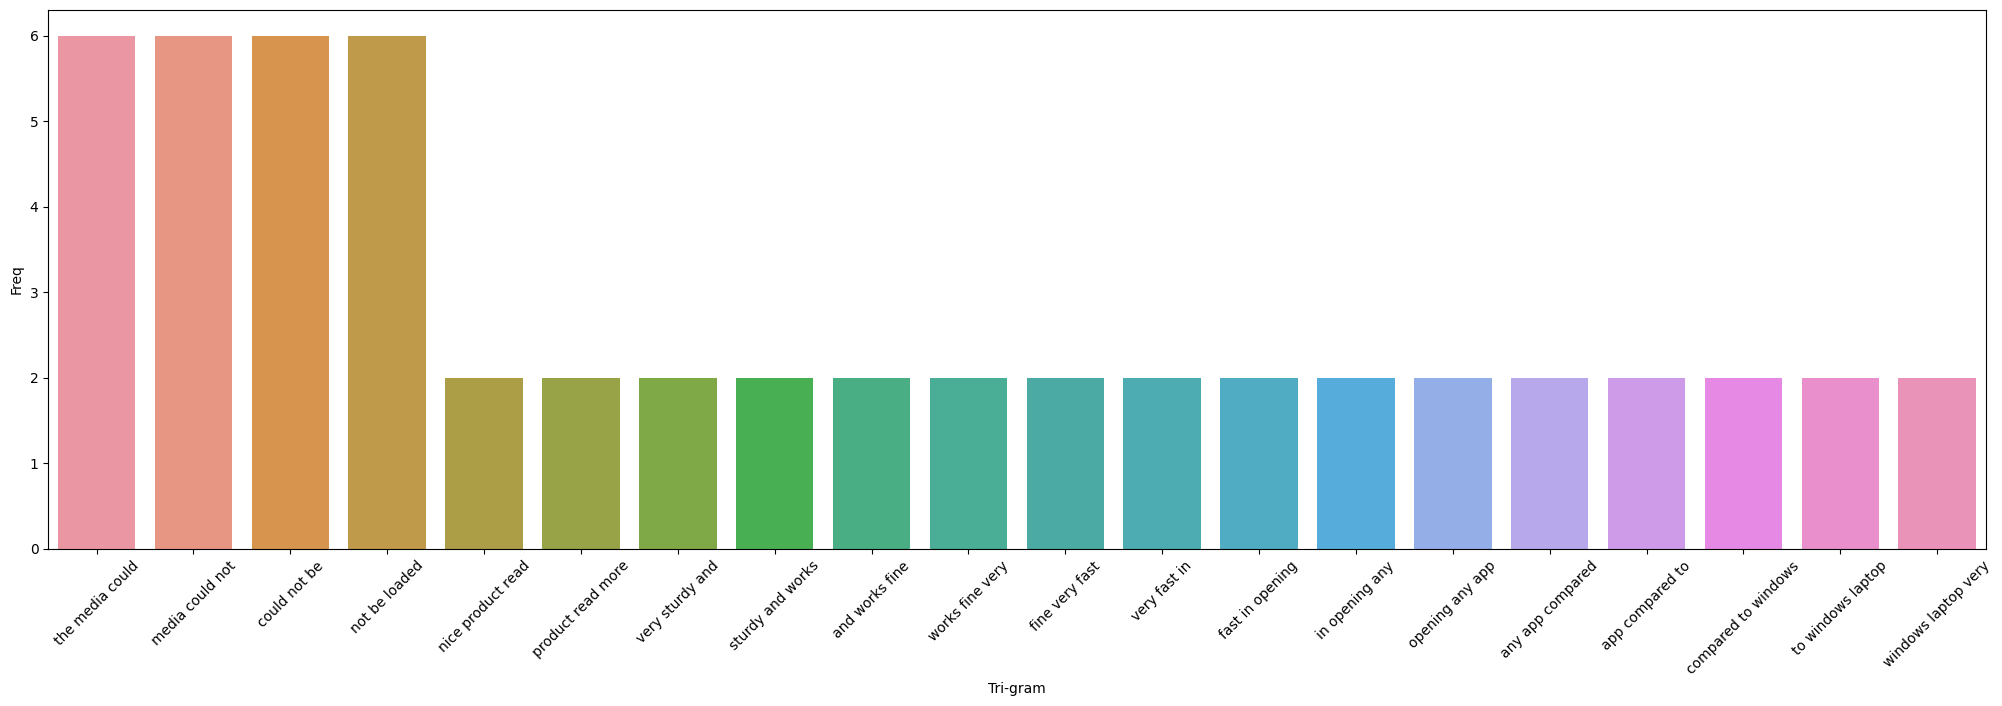

In [ ]:
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize = (25, 7))
plot=sns.barplot(x=top20_trigram["Tri-gram"],y=top20_trigram["Freq"])
plot.set_xticklabels(rotation=45,labels = top20_trigram["Tri-gram"])

In [ ]:
string_total = " ".join(df_new["Cleaned_Reviews"])
string_total[:2000]

'nice product\nread more very sturdy and works fine very fast in opening any app compared to windows laptop very light weight long lasting battery\nread more overall it has been a good experience transaction was smooth and swift accessories came in as promised mouse was faulty and had to be replaced which was easy and swift thats amazon m2 is quite easy to use and equipped with innovative features for the inquisitive user yes it may take a while to learn and get used to the new commandsbut its worth itanyway learning never stops can recommend buying through amazon without hesitation\nread more the media could not be loaded\n                \n\n\nread more the media could not be loaded\n                \n\n\n\n\xa0one of the most premium  lightest laptop  works fast and seemless with my iphone display is beautiful and looks very modern and fancy build quality is great speakers are stereo and have high volume capacity without any distortion everything is best\nread more the media could n

In [ ]:
def fetch_sentiment_using_textblob(text):
 analysis = TextBlob(text)
 return 'positive' if analysis.sentiment.polarity >= 0 else 'negative'


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
